In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import groupby
from operator import itemgetter
import parallel_plume_sim as pps
import multiprocessing
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable


def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [2]:
puff_data_filename = '~/An/data/Oct29Plumes/puff_data_20241029_101718.pickle'

# how many seconds to include per chunk?
max_time = 10

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 50

min_y = -25
max_y = 25

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718 exists, contains 26 files.


Removed all files in:  /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718


In [2]:
# This should match your directory name from above -- you need to change this
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718/'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

### Generate Trajectories and Collect Odor Encounters

In [ ]:
def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y


def scale_trajectory_to_plume_limits(trajectory_df, x_min=0, x_max=100, y_min=-40, y_max=40):
    df_scaled = trajectory_df.copy()
    
    # Get current limits
    x_orig = df_scaled.distance_along_streakline.values
    y_orig = df_scaled.nearest_from_streakline.values
    
    x_orig_min, x_orig_max = np.min(x_orig), np.max(x_orig)
    y_orig_min, y_orig_max = np.min(y_orig), np.max(y_orig)
    
    # Scale x values to new range
    df_scaled['distance_along_streakline'] = (x_orig - x_orig_min) / (x_orig_max - x_orig_min) * (x_max - x_min) + x_min
    
    # Scale y values to new range
    df_scaled['nearest_from_streakline'] = (y_orig - y_orig_min) / (y_orig_max - y_orig_min) * (y_max - y_min) + y_min
    
    return df_scaled

In [65]:
def process_and_save_existing_trajectory(foldername, dfres):
    # Extract x and y from dfres
    x = dfres.distance_along_streakline.values
    y = dfres.nearest_from_streakline.values
    time = np.linspace(0, 199, len(x))  # Assuming a time array for the length of trajectory
    # time = dfres.time if time is also provided in the file

    # Process the trajectory using multiprocessing
    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    # Extract results for concentration and wind
    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    # Create DataFrame with encounter information
    df_new = pd.DataFrame()
    df_new['time'] = time
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['distance_along_streakline'] = x
    df_new['nearest_from_streakline'] = y

    # Save processed data
    processed_filename = f'/home/gorilla/An/data/Oct29Plumes/{foldername}/diag.h5'
    df_new.to_hdf(processed_filename, key='data', mode='w')

### loading plume from pps
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_111917/'
puff_reader = pps.read_puff_data.PuffReader(dirname)
### playing desert trajectory
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5')
dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign
dfres = scale_trajectory_to_plume_limits(dfres, x_min=0, x_max=100, y_min=-40, y_max=40)

process_and_save_existing_trajectory('train_raw', dfres)


### Load the dataframe

In [3]:
def get_index(data,th):
    idx = []
    for i in range(len(data)):
        if (data[i]>=th):
            idx.append(i)
    
    
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index



def sqrt_min_max_scale(data):
    data_sqrt = np.sqrt(data)
    min_val = np.min(data_sqrt)
    max_val = np.max(data_sqrt)
    return (((data_sqrt - min_val) / (max_val - min_val)) * 10)

def power_min_max_scale(data, exponent=0.5):
    data_power = np.power(data, exponent)
    min_val = np.min(data_power)
    max_val = np.max(data_power)
    return (((data_power - min_val) / (max_val - min_val)) * 10)



dfres = pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/diag.h5')
dfres['odor'] = sqrt_min_max_scale(dfres['odor'])

# (dfres['odor'] > 0.0001).sum()
# dfres['scaled_odor'] = sqrt_min_max_scale(dfres.odor)*5.8
# (dfres['scaled_odor'] > 4.5).sum()

In [4]:
np.std(dfres.odor)*2.2

0.5089890822748017

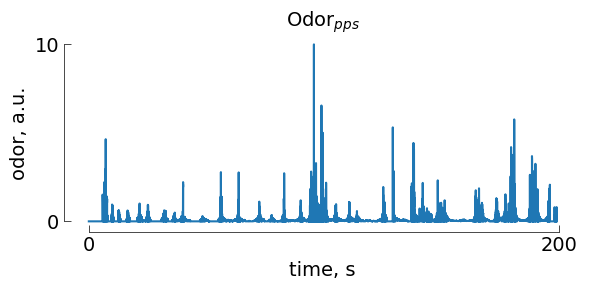

In [5]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(dfres.time, dfres.odor)
mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                            spine_locations={'left': 1,'bottom':1}, 
                            smart_bounds=True,
                            xticks=[0, 200],
                            yticks=[0,10],
                            linewidth=0.5)
ax.set_xlabel('time, s')
ax.set_ylabel('odor, a.u.')
ax.set_title('Odor$_{pps}$')


mpl_functions.set_fontsize(f, 14)
f.tight_layout()



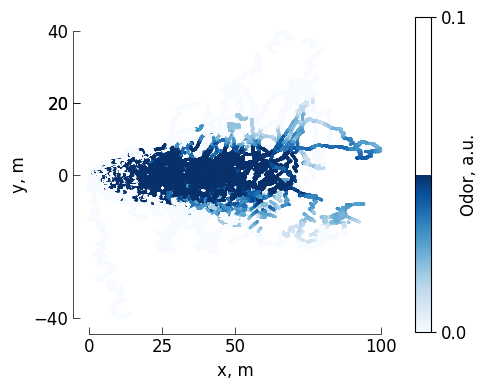

In [6]:
f,ax=plt.subplots(1,1,figsize=(5,4))
cax1=ax.scatter(dfres['distance_along_streakline'], dfres['nearest_from_streakline'], c=dfres['odor'], s=1, cmap='Blues', vmin=0, vmax=0.05)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50,100],
                            yticks=[-40,20,0,20,40],
                            linewidth=0.5)
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb1.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,0.1])
mpl_functions.set_fontsize(ax, 12)
f.tight_layout()

In [8]:
index = get_index(dfres.odor,0.05)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

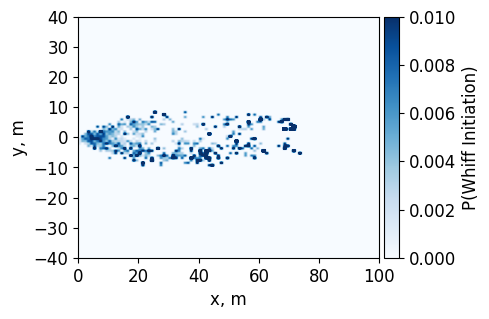

In [9]:
n_bins_x = n_bins_y = 100
heatmap_whiff, xedges, yedges = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y], 
    weights=dfres['whiff_flag']
)

heatmap_total, _, _ = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y]
)

# Calculate empirical probabilities (Equation 1)
with np.errstate(divide='ignore', invalid='ignore'):
    heatmap_prob = np.divide(
        heatmap_whiff, 
        heatmap_total, 
        out=np.zeros_like(heatmap_whiff), 
        where=heatmap_total != 0
    )

f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    heatmap_prob.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')
mpl_functions.set_fontsize(f,12)
f.tight_layout()

Optimal Parameters:
A = 0.018921135839807805
x0 = 0.0
y0 = 0.0
sigma_y = 0.3541299902434488
dy = 0.55
dist x = 1.0


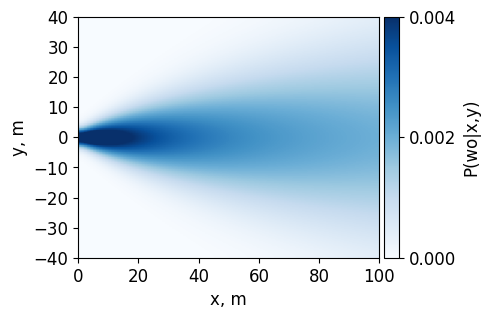

In [10]:

# Set up grid for analysis
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Prepare data for optimization
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Filter valid bins
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
    distance_x = x - x0
    distance_y = y - y0
    # distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # Simple sigma_y growth
    sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)  # stronger growth with distance
    
    # Basic Gaussian terms
    gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
    # decay_term_x = np.exp(-decay_factor_x * distance_x)
    decay_term_x = 1 / (1 + decay_factor_x * np.power(distance_x, 0.5))  # Power law decay
    

    
    return A * gaussian_y * decay_term_x

bounds = [
    (0, 1),  # A (amplitude)
    (0, 0),          # x0 fixed
    (0, 0),          # y0 fixed
    (0.2, 5.0),      # base_sigma_y
    (0.55, 2.0),     # distance_scale_factor_y - for gradual spread
    (0.02, 1)        # decay_factor_x
]

# initial_params = [0.01, 0.0, 0.0, 0.1, 1.0, 0.02]
initial_params = [0.5, 0.0, 0.0, 1.0, 0.3, 0.005]

# Negative log-likelihood function
def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x = params
    p = directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_y = {optimal_params[3]}")
print(f"dy = {optimal_params[4]}")
print(f"dist x = {optimal_params[5]}")


# Compute fitted probabilities
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
# After calculating fitted_p
scaling_factor = 1.15  # adjust this value as needed
fitted_p = fitted_p * scaling_factor
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2  # Narrower smoothing for sharper transitions
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(
    fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing
)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.004
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(cax, cax=cbar, label='P(wo|x,y)')
cb1.set_ticks([0,0.002, 0.004])
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')

mpl_functions.set_fontsize(f,12)
f.tight_layout()


In [11]:
dfres['distance_from_source'] = np.sqrt((dfres.distance_along_streakline)**2 + (dfres.nearest_from_streakline)**2)

In [143]:
import odor_stat_calculations as osc
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 0.1
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

In [144]:
from plume_sim_batch import COSMOSBatch

# # Extract required parameters
test_locations = dfres[['distance_along_streakline', 'nearest_from_streakline']].values
# fitted_p_heatmap = hmap_data['fitted_heatmap']
# xedges = hmap_data['xedges']
# yedges = hmap_data['yedges']

fitted_p_heatmap = smoothed_fitted_p_heatmap*10

# Create predictor directly and customize if needed
predictor = COSMOSBatch(
    fitted_p_heatmap=fitted_p_heatmap,
    xedges=xedges,
    yedges=yedges,
    fdf=fdf,
    fdf_nowhiff=fdf_nowhiff,
    test_locations=test_locations
)
predictor.base_odor_level=0.0001
predictor.low_threshold=0.04
results = predictor.predict()

# Use the results
dfres.loc[:, 'predicted_odor'] = results['concentrations']
dfres.loc[:, 'whiff_predicted'] = results['predictions']
# df_test.loc[:, 'logistic_transform'] = results['logistic_transform']
# df_test.loc[:, 'ar2_output'] = results['ar2_output']
# df_test.loc[:, 'target_concentration'] = results['target_concentration']

In [145]:
df_test=dfres.copy()    

In [146]:
# th=0.1
query1 = 'odor>'+ str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)


query2 = 'predicted_odor>'+ str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)


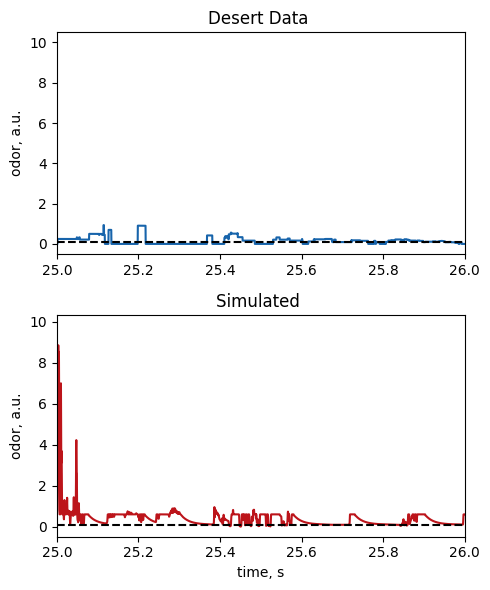

In [147]:

f,ax= plt.subplots(2,1,figsize=(5,6))
ax[0].plot(df_test.time, df_test.odor, label='original', c='#1764ab')
ax[1].plot(df_test.time, df_test.predicted_odor, label='predicted', c='#bc141a')
ax[0].axhline(th, color = 'black', linestyle = '--')
ax[1].axhline(th, color = 'black', linestyle = '--')
limit = (25,26)
ax[0].set_xlim(limit)
ax[1].set_xlim(limit)

# ax2.set_ylim(0,11)
ax[0].set_ylabel('odor, a.u.')
ax[1].set_ylabel('odor, a.u.')
ax[1].set_xlabel('time, s')
ax[0].set_title('Desert Data ')
ax[1].set_title('Simulated ')
# ax[0].set_xticklabels([])
# ax[1].set_xticklabels([])
# ax[0].set_ylim(0,10)
# ax[0].set_ylim(0,0.01)
# for i in range(2):
#     mpl_functions.adjust_spines(ax[i],['left','bottom'],
#                             spine_locations={'left': 6}, 
#                             smart_bounds=True,
#                             xticks=[75,100],
#                             # yticks=[0, 10],
#                             linewidth=0.5)
#     mpl_functions.set_fontsize(ax[i],12)
f.tight_layout()

In [148]:
np.min(fdf.odor_intermittency)

0.0

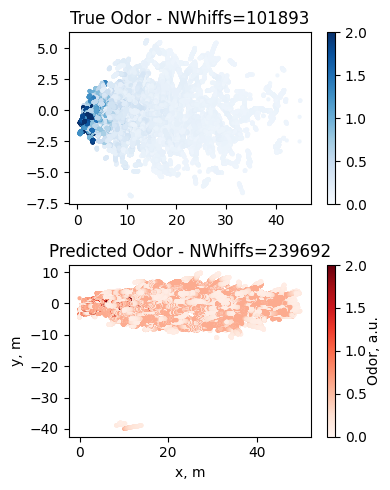

In [149]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=2)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Reds', vmin=0, vmax=2)
ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[0].set_title('Desert Data')
# ax[1].set_title('Simulated')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=0)
# cb1.set_ticks([0,10])
# cb2.set_ticks([0,10])
# for i in range(2):
#     mpl_functions.adjust_spines(ax[i],['left','bottom'],
#                             spine_locations={'left': 1}, 
#                             smart_bounds=True,
#                             xticks=[0,25,50],
#                             yticks=[-15,0,15],
#                             linewidth=0.5)
#     mpl_functions.set_fontsize(ax[i],12)

f.tight_layout()

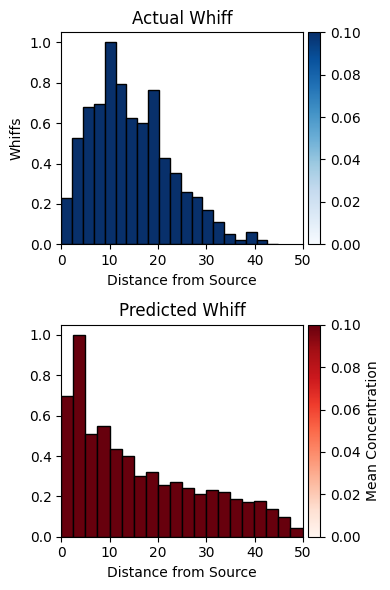

In [150]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(0,0.1)
colors_actual = plt.cm.Blues(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='Blues', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(0,0.1)
colors_predicted = plt.cm.Reds(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='Reds', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()

In [151]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [152]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 0.05
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8750.53it/s]


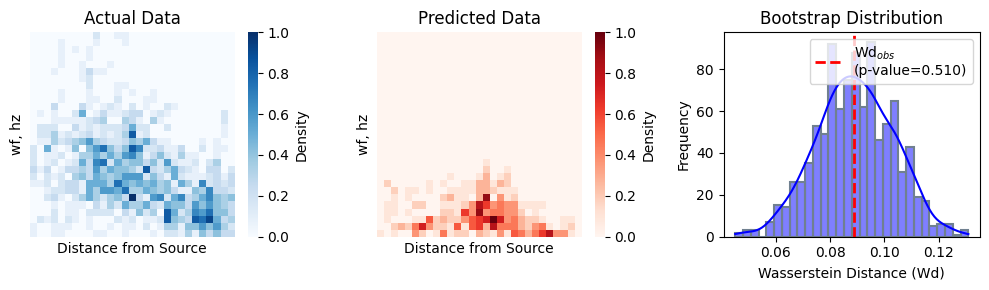

In [153]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz', 0,1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7968.40it/s]


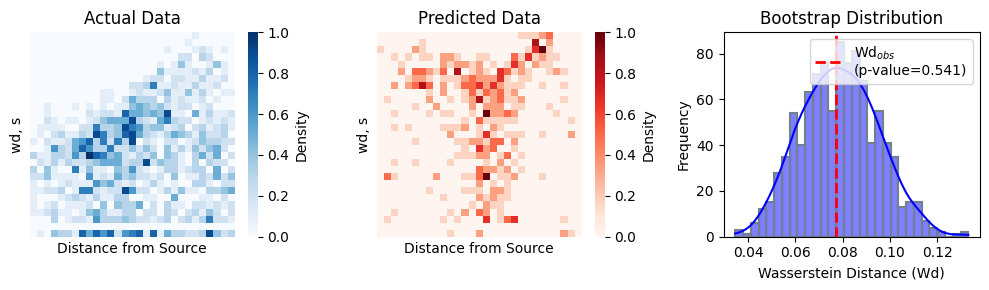

In [154]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'wd, s', 0,1)

100%|██████████| 1000/1000 [00:00<00:00, 10743.22it/s]


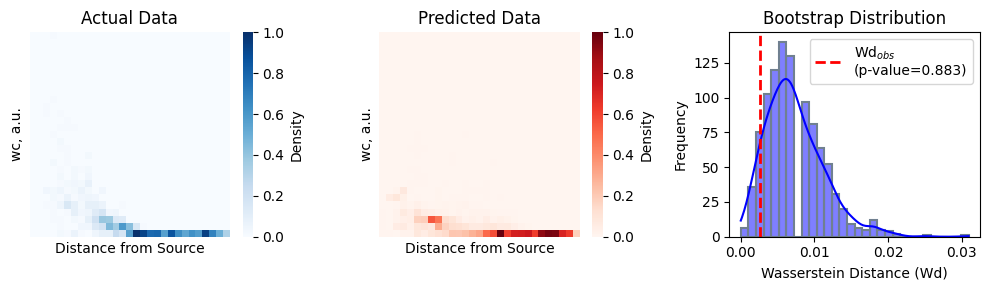

In [50]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.', 0,1)

100%|██████████| 1000/1000 [00:00<00:00, 11055.56it/s]


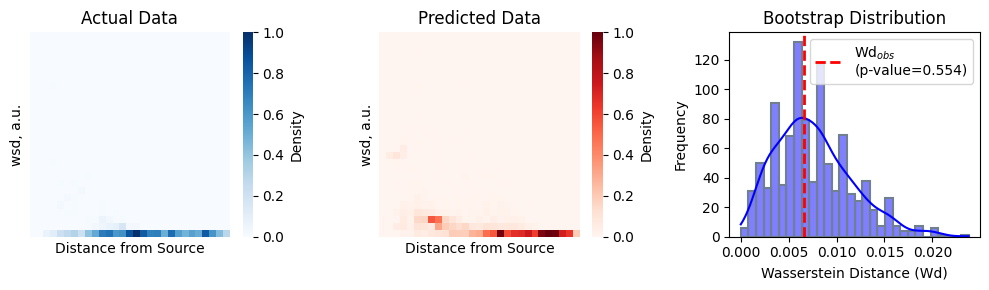

In [51]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,1)

100%|██████████| 1000/1000 [00:00<00:00, 10888.89it/s]


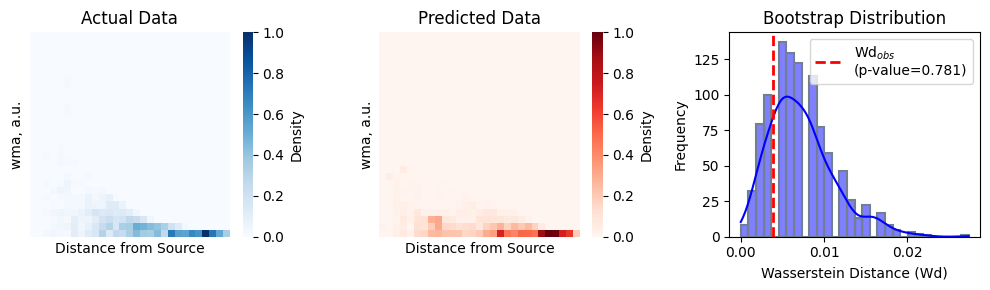

In [52]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,1)

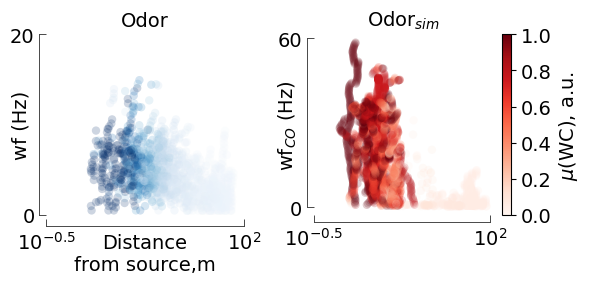

In [89]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='Blues', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=1)
ax1.set_ylabel('Whiff Frequency (Hz)')

ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='Reds', edgecolors='none', alpha=0.2, vmin=0, vmax=1)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{sim}$')
ax1.set_xlabel('Distance\nfrom source,m')
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{CO}$ (Hz)')


# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 5, 'bottom': 8},
                            smart_bounds=True,
                            xticks=[-0.5, 2],
                            yticks=[0, 20],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 5, 'bottom': 5},
                            smart_bounds=True,
                            xticks=[-0.5, 2],
                            yticks=[0, 60],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
# ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{2}$'])
# ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

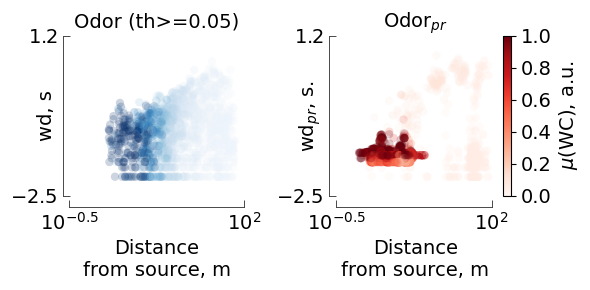

In [90]:
### WHIFF DURATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='Blues',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=1  )
ax1.set_ylabel('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance\nfrom source, m')
ax1.set_ylabel('wd, s')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, c=fdf_predicted.mean_concentration, cmap='Reds',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=1)
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')


ax2.set_xlabel('Distance\nfrom source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)


mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 5, 'bottom': 8},
                            smart_bounds=True,
                            xticks=[-0.5, 2],
                            yticks=[-4.0,1.2],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 5, 'bottom': 8},
                            smart_bounds=True,
                            xticks=[-0.5, 2],
                            yticks=[-4.0,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$-2.5$', r'$1.2$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$-2.5$', r'$1.2$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{2}$'])


mpl_functions.set_fontsize(f, 14)
f.tight_layout()
